In [1]:
#If files have been already dumped in parquet format
import uproot, numpy as np, awkward as ak
from glob import glob
from tqdm import tqdm
from collections import defaultdict
import awkward as ak
import os, pathlib
from pathlib import Path
import ROOT
%load_ext autoreload
%autoreload 2

from utils import *

parq_dir = Path("parquet_out")

# pick just the trees you need
need = [
    "ticlTrackstersCLUE3DHigh",
    "ticlCandidate",
    "simtrackstersCP",
    "associations",
    "clusters",
]

dump_data = {name: ak.from_parquet(parq_dir / f"{name}.parquet")
             for name in need}

# ── usage ────────────────────────────────────────────────────────────────
ticlTrackstersCLUE3D = dump_data["ticlTrackstersCLUE3DHigh"]
ticlCandidate = dump_data["ticlCandidate"]
simTrackstersCP = dump_data["simtrackstersCP"] 
associations = dump_data["associations"]
clusters = dump_data['clusters']
assert len(associations) == len(simTrackstersCP)

In [2]:
# import sys
# !{sys.executable} -m pip install -- CLUEstering

In [3]:
import sys
import site


user_site = site.getusersitepackages()
if user_site not in sys.path:
    sys.path.append(user_site)

import CLUEstering as clue

# Baseline

In [4]:
sim_to_reco_tables = []
reco_to_sim_tables = []
all_merged_reco    = []
Nevents = 1000
for ev in tqdm(range(Nevents)):
    reco_ev = ticlCandidate[ev]
    sim_ev  = simTrackstersCP[ev]

    # no Trackster objects: just dict views
    merged_reco = event_to_views(reco_ev)
    all_merged_reco.append(merged_reco)

    if len(sim_ev.raw_energy) == 0:
        sim_to_reco_tables.append([])
        reco_to_sim_tables.append([])
        continue

    sim_to_reco_tables.append(
        compute_sim_to_reco_scores(sim_ev, merged_reco, best_only=True)
    )
    reco_to_sim_tables.append(
        compute_reco_to_sim_scores(sim_ev, merged_reco, best_only=False)
    )




100%|██████████| 1000/1000 [00:34<00:00, 28.96it/s]


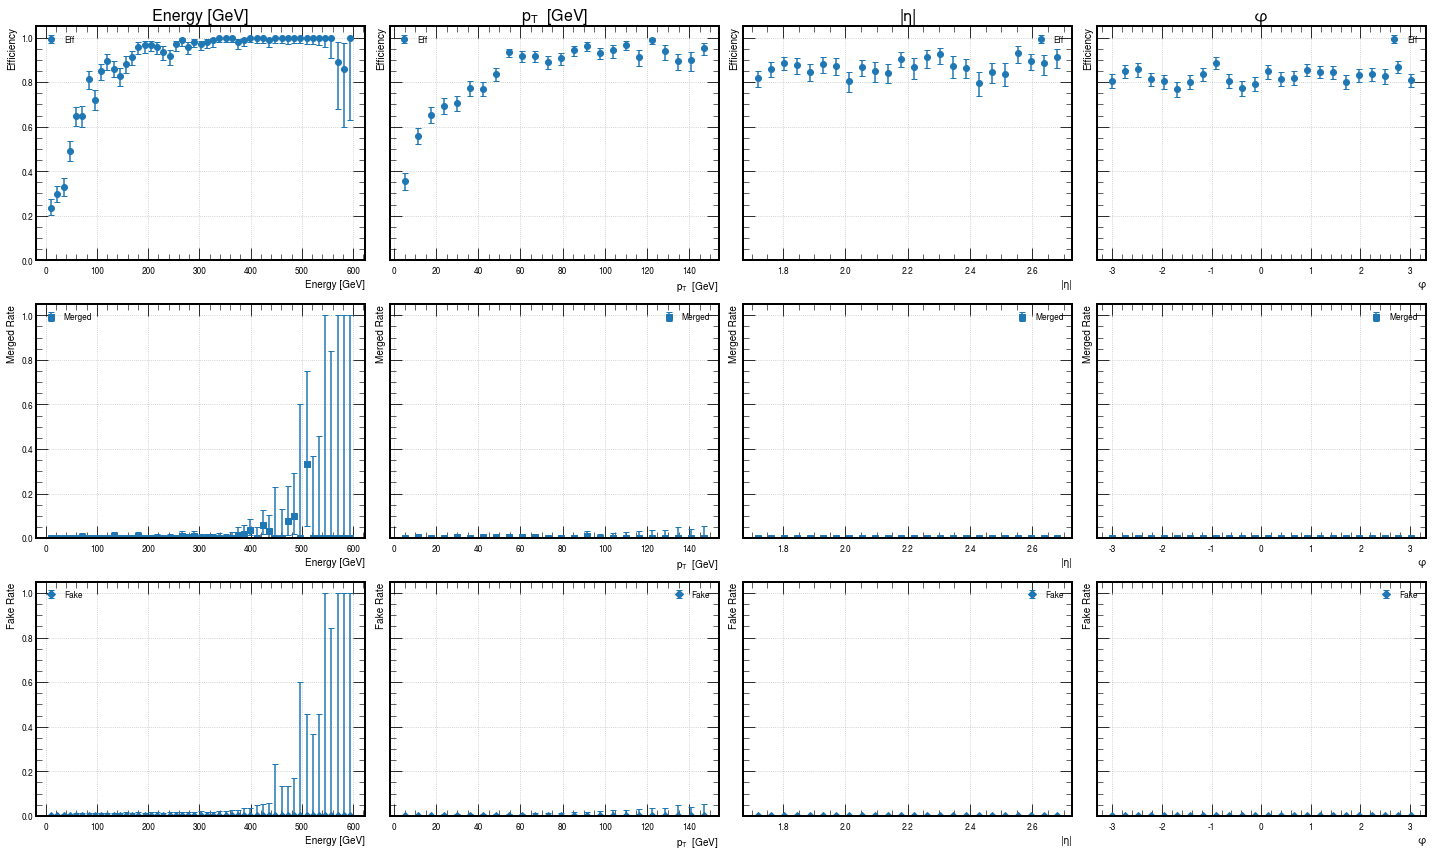

In [5]:
data_efficiency = aggregate_for_efficiency(simTrackstersCP, sim_to_reco_tables,
                           score_threshold=0.5)
data_merged = aggregate_for_merge(all_merged_reco, reco_to_sim_tables,
                           score_threshold=0.6)
data_fake = aggregate_for_fake(all_merged_reco, reco_to_sim_tables,
                           score_threshold=0.6)
plot_all_metrics(
    data_efficiency,
    data_merged,
    data_fake,
    out_file="ticl_metrics_baseline.pdf"   # omit if you don’t need a file
)

# New Algo

In [6]:
import random, functools
import numpy as np

#To use for merging Tracksters together
def merge_views(a: dict, b: dict) -> dict:
    """Return a NEW dict that is the energy-weighted merge of a & b."""
    Ea, Eb = a["raw_energy"], b["raw_energy"]
    Etot   = Ea + Eb if (Ea + Eb) else 1.0          # avoid /0

    # energy-weighted barycentres
    bx = (a["barycenter_eta"] * Ea + b["barycenter_eta"] * Eb) / Etot
    by = (a["barycenter_phi"] * Ea + b["barycenter_phi"] * Eb) / Etot

    # concatenate LC arrays
    v_idx = a["vertices_indexes"] + b["vertices_indexes"]
    v_E   = a["vertices_energy"]  + b["vertices_energy"]
    v_mul = a["vertices_multiplicity"] + b["vertices_multiplicity"]

    merged = dict(a)              # shallow copy of first view
    merged.update(
        raw_energy=Etot,
        regressed_pt=a.get("regressed_pt", np.nan) +      # placeholder logic
                     b.get("regressed_pt", np.nan),
        barycenter_eta=bx,
        barycenter_phi=by,
        vertices_indexes=v_idx,
        vertices_energy=v_E,
        vertices_multiplicity=v_mul,
    )
    return merged

#Your algo
def random_group_merging(event_rec, *, max_group_size=3, rng=None):
    """
    Returns list[dict] of possibly-merged Reco tracksters for one event.
    Works entirely with dict views => no deepcopy cost.
    """
    if rng is None:
        rng = random
    n = len(event_rec.raw_energy)
    if n == 0:
        return []

    views = event_to_views(event_rec)   # one dict per Reco trackster

    idxs = list(range(n))
    rng.shuffle(idxs)

    groups, cur = [], 0
    while cur < n:
        gsize = min(rng.randint(1, max_group_size), n - cur)
        groups.append(idxs[cur : cur + gsize])
        cur += gsize

    merged_out = []
    for g in groups:
        if len(g) == 1:
            merged_out.append(views[g[0]])
        else:
            merged = functools.reduce(lambda a, b: merge_views(a, b),
                                      (views[i] for i in g))
            merged_out.append(merged)
    return merged_out


In [7]:
from tqdm import tqdm
import random


sim_to_reco_tables = []    
reco_to_sim_tables = []    
all_merged_reco    = []    

rng = random.Random(123)

Nevents = 1000     # or any shorter “range(N)”
for ev in tqdm(range(Nevents), desc="events"):
    reco_ev = ticlTrackstersCLUE3D[ev]     
    sim_ev  = simTrackstersCP[ev]          

    merged_reco = random_group_merging(reco_ev, rng=rng)

    all_merged_reco.append(merged_reco)

    if len(sim_ev.raw_energy) == 0:
        sim_to_reco_tables.append([])
        reco_to_sim_tables.append([])
        continue

    sim_to_reco_tables.append(
        compute_sim_to_reco_scores(sim_ev, merged_reco, best_only=True)
    )
    reco_to_sim_tables.append(
        compute_reco_to_sim_scores(sim_ev, merged_reco, best_only=False)
    )



events: 100%|██████████| 1000/1000 [01:04<00:00, 15.59it/s]


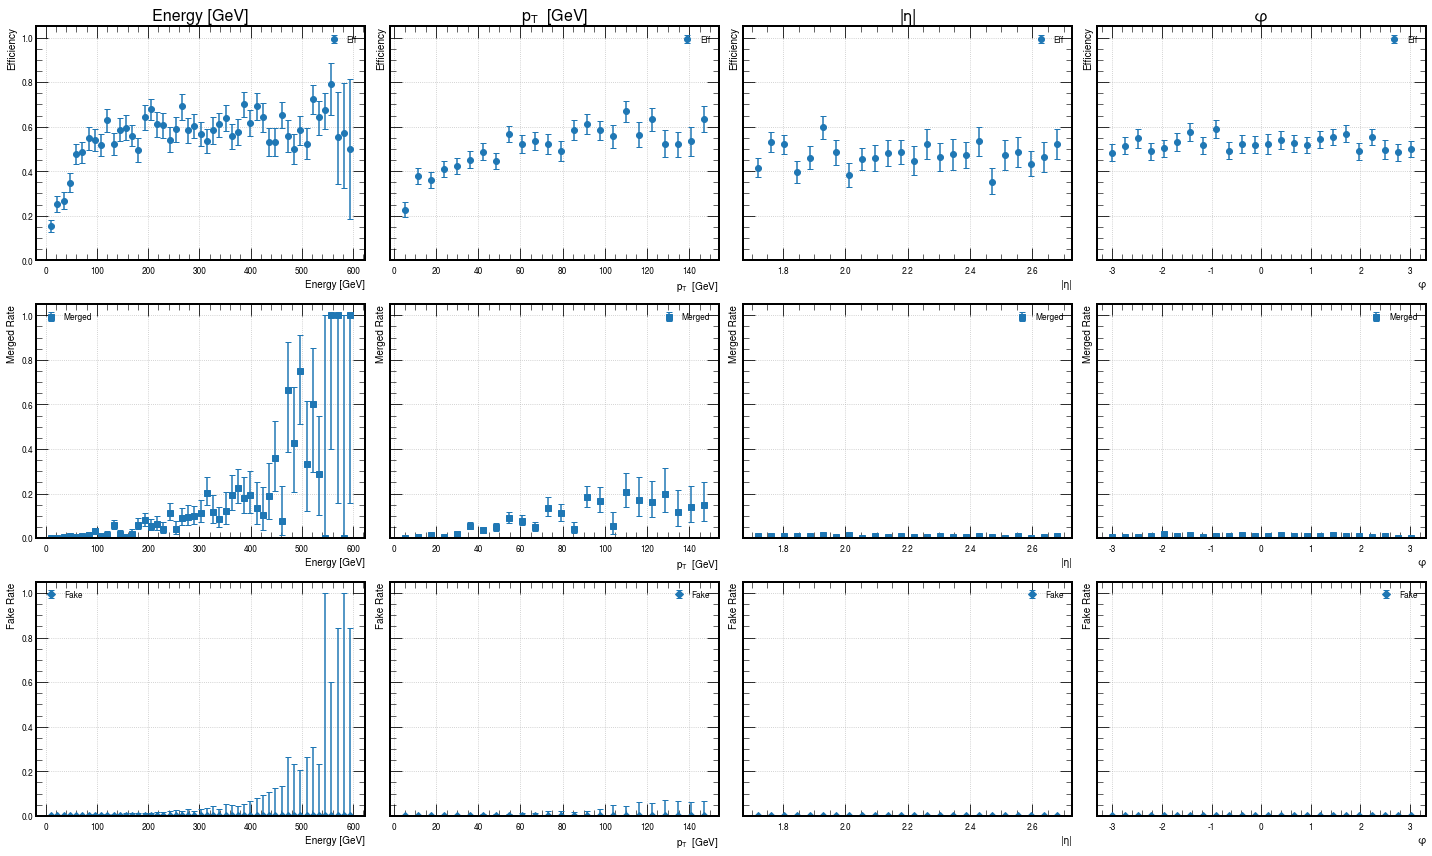

In [8]:

data_efficiency = aggregate_for_efficiency(
    simTrackstersCP, sim_to_reco_tables, score_threshold=0.5
)
data_merged = aggregate_for_merge(
    all_merged_reco, reco_to_sim_tables, score_threshold=0.6
)
data_fake = aggregate_for_fake(
    all_merged_reco, reco_to_sim_tables, score_threshold=0.6
)

plot_all_metrics(
    data_efficiency,
    data_merged,
    data_fake,
    out_file="ticl_metrics_grid.pdf" 
)

# Produce CLUE3D Tracksters 

In [9]:
from tqdm import tqdm
import pandas as pd
import random

sim_to_reco_tables = []
reco_to_sim_tables = []
all_merged_reco    = []

dc, rhoc, outlier_factor = 0.6, 2.0, 1.5
rng = random.Random(123)

Nevents = 100
for ev in tqdm(range(Nevents), desc="CLUE events"):
    event_lc = clusters[ev]               # Awkward record for this event

    # 1) build DataFrame for CLUE
    df = pd.DataFrame({
        "x":      ak.to_numpy(event_lc.position_x),
        "y":      ak.to_numpy(event_lc.position_y),
        "z":      ak.to_numpy(event_lc.position_z),
        "weight": ak.to_numpy(event_lc.energy),
    })

    # 2) run CLUE
    cl = clue.clusterer(dc, rhoc, outlier_factor)
    cl.read_data(df)
    cl.run_clue()                          # cl.cluster_points → array of lists/scalars

    # 3) convert CLUE clusters → Reco trackster dict views
    reco_views = clue_clusters_to_reco_views(event_lc, cl.cluster_points)
    all_merged_reco.append(reco_views)

    # 4) Sim ↔ Reco scoring
    sim_ev = simTrackstersCP[ev]
    sim_to_reco_tables.append(
        compute_sim_to_reco_scores(sim_ev, reco_views, best_only=True)
    )
    reco_to_sim_tables.append(
        compute_reco_to_sim_scores(sim_ev, reco_views, best_only=False)
    )


CLUE events: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


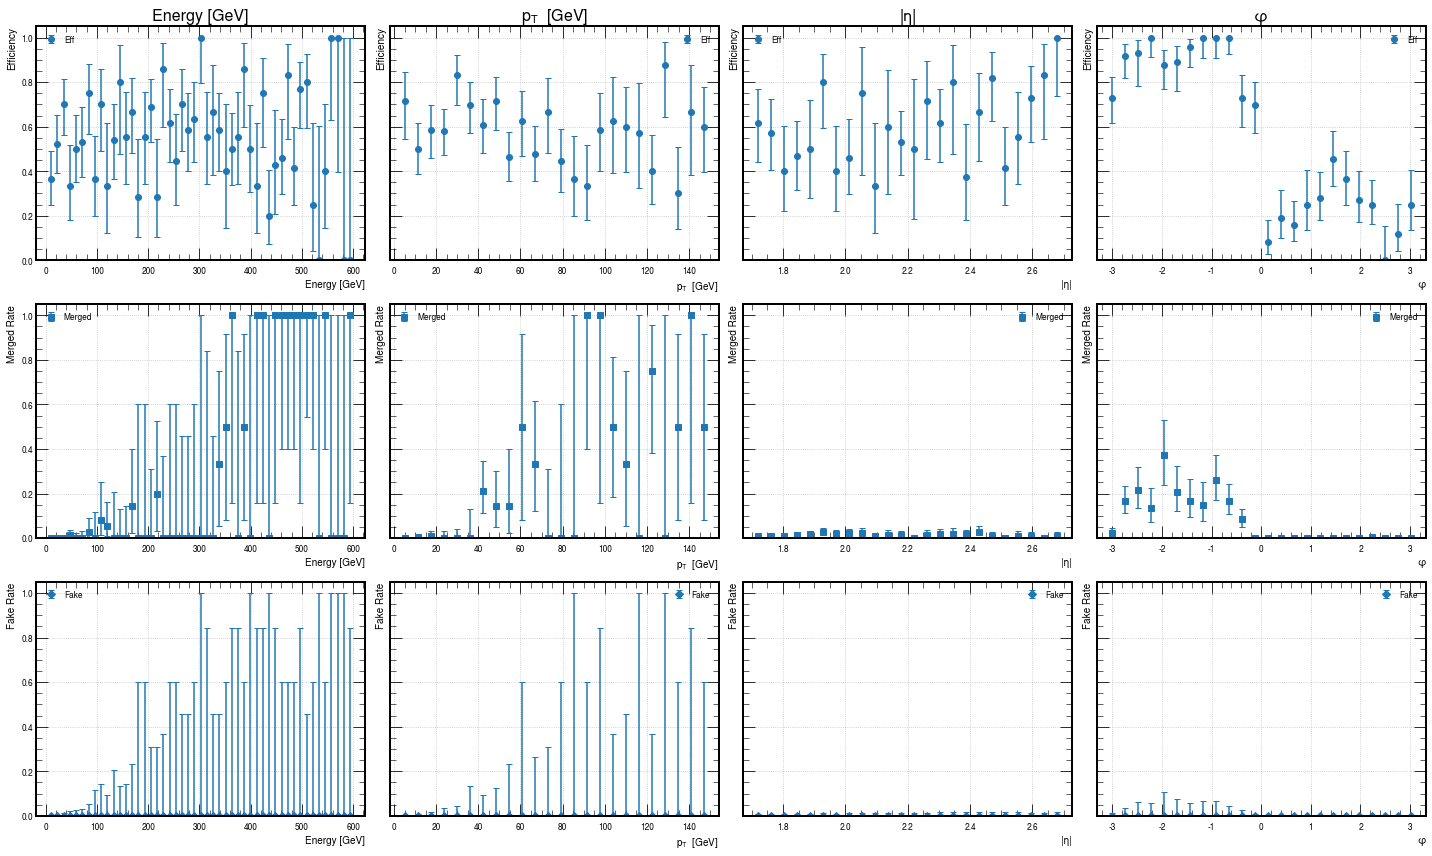

In [10]:
data_efficiency = aggregate_for_efficiency(simTrackstersCP, sim_to_reco_tables,
                           score_threshold=0.5)
data_merged = aggregate_for_merge(all_merged_reco, reco_to_sim_tables,
                           score_threshold=0.6)
data_fake = aggregate_for_fake(all_merged_reco, reco_to_sim_tables,
                           score_threshold=0.6)
plot_all_metrics(
    data_efficiency,
    data_merged,
    data_fake,
    out_file="ticl_metrics_baseline.pdf"   # omit if you don’t need a file
)